In [1]:
# load packages
library(tidyverse)
library(phyloseq)
library(qiime2R)
library(randomForestSRC)
library(magrittr)
library(scales)
library(grid)
library(reshape2)
library(knitr)
library(ggpmisc)
library(ggpubr)

# SHAP/ML
library(shapr)
library(DALEX)
library(partykit)
library(mlr3)
library(mlr3learners)
library(ranger)
library(mlr3tuning)
library(paradox)
library(iBreakDown)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

 randomForestSRC 3.3.3 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 



Attaching package: ‘randomForestSRC’


The following object is masked from ‘package:purrr’:

    partial



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


Th

In [2]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list


tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data


taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
# Convert taxonomy info to data frame with correct taxonomy labels
#taxa <- taxa_16S[-1,]
select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11,
12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [3]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA"))


meta$Genotype = factor(meta$Genotype, levels = c("FM19", 
                                                                
                                        "FM6", "FM9", "U44",
                                        "FM14", "Elkhorn", "K2",
                                        "Acerv2", "Kelsey-1", "Cooper-9", "U41"
                                                                ))

In [4]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps

dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")
ps <- subset_samples(ps, !ID %in% dups & !is.na(Genotype) & Genotype != "U41")

 
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [5]:
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped


ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired

ps_both = subset_samples(ps_Clipped, filter_unpair=="no")
ps_both


select=c("Ambient_Pathogen", "NH4_Pathogen", "Ambient_Placebo", "NH4_Placebo")
ps_disease <- subset_samples(ps_both, Combo %in% select)
ps_disease

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 151 samples ]
sample_data() Sample Data:       [ 151 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [6]:
sample_data(ps_disease) %>%
  group_by(Combo, Survivorship) %>%
  summarize(count = n())

`summarise()` has grouped output by 'Combo'. You can override using the
`.groups` argument.


Combo,Survivorship,count
<chr>,<int>,<int>
Ambient_Pathogen,0,8
Ambient_Pathogen,1,22
Ambient_Placebo,0,31
NH4_Pathogen,0,21
NH4_Pathogen,1,28
NH4_Placebo,0,56
NH4_Placebo,1,7
NH4_Placebo,NA,1


In [7]:
sample_data(ps_disease) %>%
  group_by(Combo, Health) %>%
  summarize(count = n())

sample_data(ps_disease) %>%
  group_by(Outcome) %>%
  summarize(count = n())

sample_data(ps_disease) %>%
  group_by(Health) %>%
  summarize(count = n())

`summarise()` has grouped output by 'Combo'. You can override using the
`.groups` argument.


Combo,Health,count
<chr>,<chr>,<int>
Ambient_Pathogen,AH,8
Ambient_Pathogen,DL,22
Ambient_Placebo,AH,30
Ambient_Placebo,DL,1
NH4_Pathogen,AH,20
NH4_Pathogen,DL,29
NH4_Placebo,AH,43
NH4_Placebo,DL,21


Outcome,count
<chr>,<int>
Healthy,30
Unaffected,71
Unhealthy,73


Health,count
<chr>,<int>
AH,101
DL,73


In [8]:
ps_fill_clip = filter_taxa(ps_Clipped, function(x) sum(x > 5) > (0.01*length(x)), TRUE)
ps_fill_clip                           


                          
ps_fill_disease = filter_taxa(ps_disease, function(x) sum(x > 5) > (0.05*length(x)), TRUE)
ps_fill_disease   

#ps_fill_disease= filter_taxa(ps_fill_disease, function(x) sum(x) > 150, TRUE)    
#ps_fill_disease                          

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1845 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 1845 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1845 tips and 1561 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 232 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 232 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 232 tips and 193 internal nodes ]

In [9]:
set.seed(1234)

In [10]:


# select column as response variable 
predictors <- t(otu_table(ps_fill_disease))
dim(predictors)
response <- as.factor(sample_data(ps_fill_disease )$Health)
rf.data <- data.frame(response, predictors)
rf.data <- rf.data[!is.na(rf.data$response), ]

# Create task and train
task <- TaskClassif$new(id = "Surv", backend = rf.data, target = "response", positive = "AH")
learner <- lrn("classif.ranger", predict_type = "prob", num.trees = 300)
learner$train(task)

# Define predict_function
predict_function <- function(model, newdata) {
  p <- model$predict_newdata(newdata)
  prob <- as.data.frame(p$prob)[, "AH"]
  names(prob) <- rownames(newdata)
  return(prob)
}

# Create explainer
explainer <- DALEX::explain(
  model = learner,
  data = rf.data[, -1],
  y = as.numeric(rf.data$response == "AH"),
  predict_function = predict_function,
  label = "Ranger"
)

# SHAP for one observation
shap <- predict_parts(
  explainer = explainer,
  new_observation = rf.data[1, -1, drop = FALSE],
  type = "shap"
)




[1] 174 232

Preparation of a new explainer is initiated
  -> model label       :  Ranger 
  -> data              :  174  rows  232  cols 
  -> target variable   :  174  values 
  -> predict function  :  predict_function 
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package Model of class: LearnerClassifRanger package unrecognized , ver. Unknown , task regression (  default  ) 
  -> predicted values  :  numerical, min =  0 , mean =  0.5886296 , max =  0.9990152  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.5800198 , mean =  -0.008169788 , max =  0.5071521  
  A new explainer has been created!  


In [11]:
learner$train(task)
prediction <- learner$predict(task)
# Confusion matrix
prediction$confusion

# Accuracy
accuracy <- prediction$score(msr("classif.acc"))

# Precision (for positive class "AH")
precision <- prediction$score(msr("classif.precision"))

# Recall (a.k.a. Sensitivity)
recall <- prediction$score(msr("classif.recall"))

# F1 score (optional)
f1 <- prediction$score(msr("classif.fbeta"))

# Print all
cat("Accuracy:", round(accuracy, 3), "\n")
cat("Precision:", round(precision, 3), "\n")
cat("Recall:", round(recall, 3), "\n")
cat("F1 Score:", round(f1, 3), "\n")

        truth
response  AH  DL
      AH 100   4
      DL   1  69

Accuracy: 0.971 
Precision: 0.962 
Recall: 0.99 
F1 Score: 0.976 


## Test model

In [12]:
# Define the resampling strategy (5-fold cross-validation)
resampling <- rsmp("cv", folds = 5)

# Perform the cross-validation
rr <- resample(task = task, learner = learner, resampling = resampling, store_models = TRUE)



INFO  [10:58:04.601] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 1/5)
INFO  [10:58:04.653] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 2/5)
INFO  [10:58:04.694] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 3/5)
INFO  [10:58:04.732] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 4/5)
INFO  [10:58:04.767] [mlr3] Applying learner 'classif.ranger' on task 'Surv' (iter 5/5)


In [13]:
#Convert SHAP results to dataframe
shap_df <- as.data.frame(shap)

#Create and clean variable_name from 'variable' column
shap_df$variable_name <- gsub(" = .*", "", shap_df$variable)                     # Remove '= value'
shap_df$variable_name <- gsub("X", "", shap_df$variable_name)                   # Remove leading 'X' from numeric feature names (if needed)
shap_df$variable_name <- tolower(shap_df$variable_name)                         # Optional: lowercase for consistency

# Prepare taxonomy table
taxonomy_df <- as.data.frame(tax_table(ps_fill_disease))
taxonomy_df$variable_name <- rownames(taxonomy_df)
taxonomy_df$variable_name <- gsub("^X", "", taxonomy_df$variable_name)          # Remove leading X if present in rownames
taxonomy_df$variable_name <- tolower(taxonomy_df$variable_name)                # Optional

#  Merge SHAP results with taxonomy info
merged_data <- dplyr::inner_join(shap_df, taxonomy_df, by = "variable_name")

# Inspect result
head(merged_data)
dim(merged_data)
#write.table(merged_data, "/Users/stephanie.rosales/Documents/omics_projects/Resitada/ML/merged_data.txt") 

,variable,contribution,variable_name,variable_value,sign,label,B,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,a0fc8d8c3c84ed90adfdb3c3828a3341 = 0,-8.445418e-05,a0fc8d8c3c84ed90adfdb3c3828a3341,0,-1,Ranger,0,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Rubritaleaceae,g__Rubritalea,s__Rubritalea_tangerina,ASV_6413
2,a14b7162edeb7a30ddb2a46656539857 = 0,-1.413836e-04,a14b7162edeb7a30ddb2a46656539857,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6427
3,a375bcfe89e6846168661528279a2e38 = 0,2.220899e-04,a375bcfe89e6846168661528279a2e38,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,ASV_6507
4,a3c29bcb6997cfe572a474e58291af1d = 0,-8.248446e-04,a3c29bcb6997cfe572a474e58291af1d,0,-1,Ranger,0,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,NA,ASV_6512
5,a3fbbac5fc06325d6d2d662fb9b47510 = 0,7.471264e-06,a3fbbac5fc06325d6d2d662fb9b47510,0,1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_6526
6,a5997412dbc7bdf31e2f533103884dbe = 0,-1.086590e-04,a5997412dbc7bdf31e2f533103884dbe,0,-1,Ranger,0,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,NA,ASV_6577


[1] 6032   15

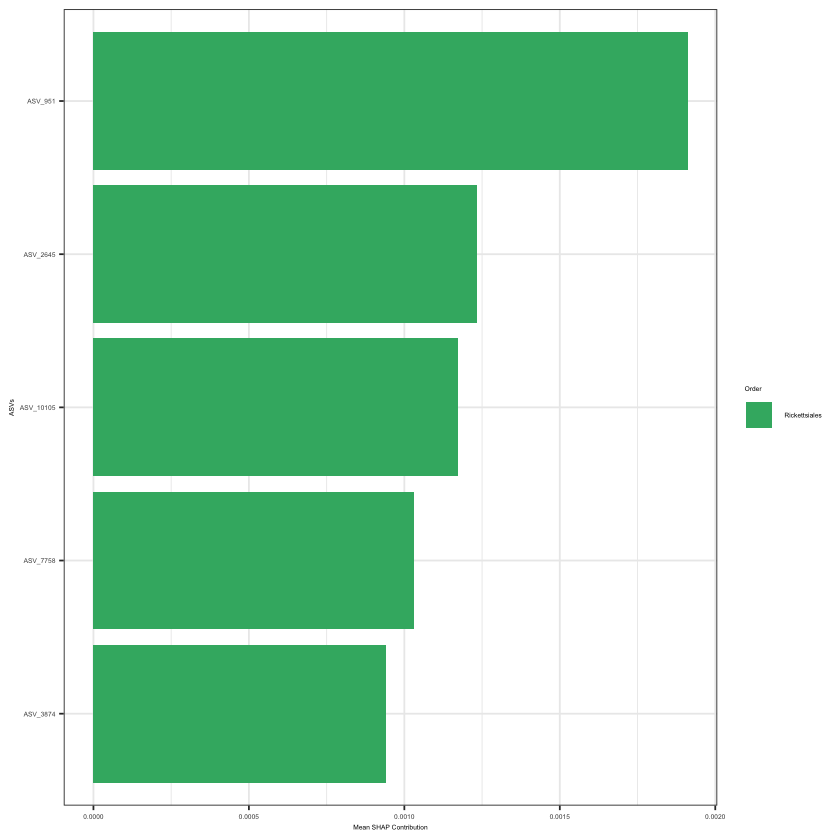

In [14]:
# Prepare top SHAP features
top_shap <- merged_data %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
filter(variable_value != 0.0) %>%
 filter(contribution > 0) %>%

  group_by(ASVs, Order) %>%
  summarize(mean_shap = mean(abs(contribution), na.rm = TRUE), .groups = "drop") %>%
#summarize(mean_shap = mean(contribution, na.rm = TRUE), .groups = "drop") %>%
  arrange(desc(mean_shap)) %>%
  slice(1:5)

# Plot
ggplot(top_shap, aes(x = reorder(ASVs, mean_shap), y = mean_shap, fill = Order)) +
  geom_col() +
  coord_flip() +
scale_fill_manual(values=c( "#3CB371","orange", "Navy"
                           )) +
  labs(x = "ASVs", y = "Mean SHAP Contribution", fill = "Order") +
  theme_bw() +
 theme(
    axis.title.x = element_text(size = 4),
    axis.title.y = element_text(size = 4),
    axis.text.x =  element_text(size = 4),
    axis.text.y = element_text(size = 4),
 
          panel.spacing.x = unit(0.0, "lines"),
    panel.spacing.y = unit(0.0, "lines"),
    legend.text = element_text(size = 4),
    legend.title = element_text(size = 4)
  ) 

ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/SuppFig8.png", 
     width =4, height = 4, units = "in", dpi=300)

In [15]:
sum_Clipped = ps_fill_disease %>%
  subset_samples(filter_unpair=="no") %>%
  tax_glom(taxrank = "ASVs") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>%# Transform to rel. abundance
  psmelt()


Warning message:
“The dot-dot notation (`..rr.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(rr.label)` instead.”


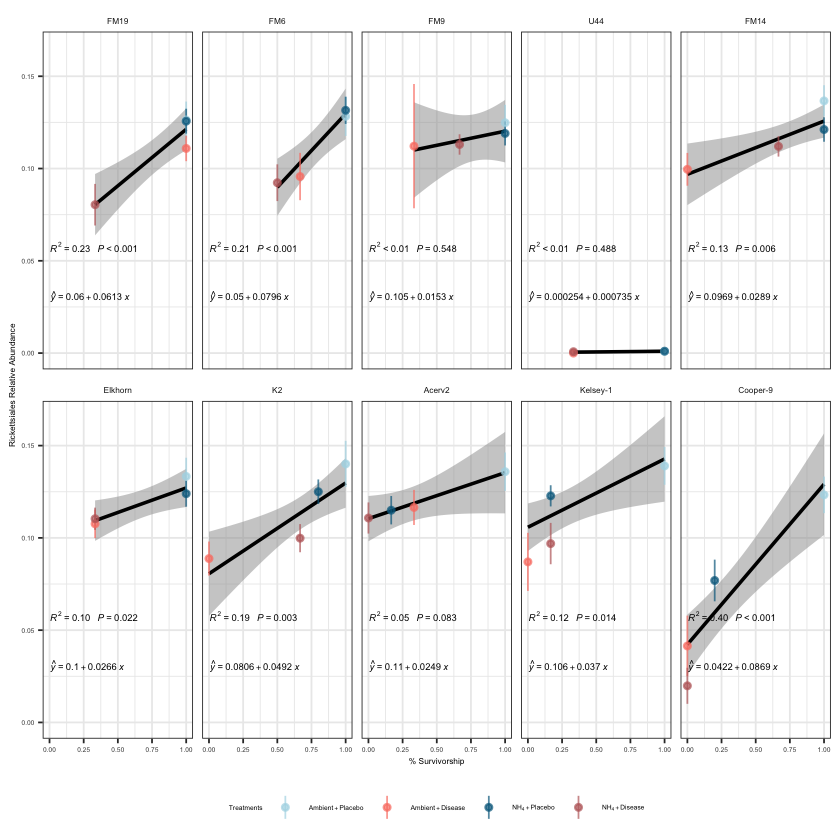

In [16]:
# Define ASVs of interest
rick <- c("ASV_951","ASV_10105", "ASV_3874")
# Reorder treatment factor levels
sum_Clipped$Combo <- factor(
 sum_Clipped$Combo,
  levels = c("Ambient_Placebo","Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen")
)

# Define plot labels
lab1 <- c(
  expression(Ambient + Placebo),
  expression(Ambient + Disease),
  expression(NH[4] + Placebo), 
  expression(NH[4] + Disease)
)

# Generate plot
sum_Clipped %>%
  filter(
    ASVs %in% rick,
    Genotype != "U41",
  ) %>%
  

  ggplot(aes(x = surv, y = Abundance, color = Combo)) +  
geom_smooth(aes(x = surv, y = Abundance), method = "lm", formula = y ~ x,  color = "black", alpha=0.5) +

    stat_summary(
    fun.data = mean_se, # or mean_cl_normal, mean_cl_boot
    geom = "pointrange",
    position = position_dodge(width = 0.0),
    size = 0.3,
    alpha = 0.7
        
  ) +
  scale_color_manual(
    "Treatments", 
    values = c("lightblue", "salmon", "#00688B", "#bc6767"), 
   labels = lab1
  ) +

  stat_poly_eq(
    formula = y ~ x,
    eq.with.lhs = "italic(hat(y))~`=`~",
    aes(label = paste(..rr.label.., ..p.value.label.., sep = "~~~")),
    parse = TRUE, 
    label.y = 0.35, 
    label.x = "left",
    color = "black", 
    rr.digits = 2,
    size = 2
  ) +

  stat_poly_eq(
    aes(label = paste(..eq.label.., sep = "~~~")), 
    formula = y ~ x,
    eq.with.lhs = "italic(hat(y))~`=`~",
    eq.x.rhs = "~italic(x)",
    parse = TRUE,
    label.y = 0.20,
    label.x = "left",
    size = 2,
    color = "black"
  ) +

  facet_wrap(Genotype ~ ., nrow=2) +

  theme_bw() +
theme(
    strip.background = element_blank(),
    strip.text.x = element_text(size = 5),
    legend.text = element_text(size = 4),
    legend.title = element_text(size = 4),
    legend.position = "bottom",
    legend.box = "horizontal",
    legend.direction = "horizontal",
    axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 5),
    axis.text.y = element_text(size = 4),
      axis.text.x = element_text(size = 4)
  ) +

  ylab("Rickettsiales Relative Abundance") +
  xlab("% Survivorship")
ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/Fig5.png", 
      width =5, height = 4, units = "in", dpi=300)